In [1]:
### imports
%matplotlib inline
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient
from influxdb import DataFrameClient
from apiclass import *
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error as mse

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
### datframe exptraction
import sys
import warnings
import pickle
from math import *
if not sys.warnoptions:
    warnings.simplefilter("ignore")

query_body = """
SELECT  npt, ngp,t5_average_temperature,engine_pcd ,t1_temperature, turb_air_inlet_filter_dp, unit_run

FROM unit1 

"""

last_predicted = dict()

last_predicted['last_value'] = 0

########The database to retrieve data from ML######################

zhost = '192.168.4.33'

zport = 8086

zuser = ''

zpassword = ''

zdb_name = 'Labview'

db_name = 'Online_Classification'

starttime = time.time()
#writer_client = DataFrameClient(host=zhost, port=zport, username=zuser, password=zpassword, database=db_name)
predictor = Online_predictor(zhost, zport, zuser, zpassword, zdb_name,query_body)
predictor.get_data_from_influx()
predictor.read_data()
df = predictor.prepare_data()
#print(df.ngp)

In [8]:
### The function divides the df into train/test and trains the model. Then it saves it using pickle. 


def serialize(param_data, filename,train_idx=slice(97000,100000),test_idx=slice(100000,103000), seasonal_periods=314):
    train, test = param_data.iloc[train_idx], param_data.iloc[test_idx]
    param_data.index.freq = 'sec'
### Holts-winters exponential smoothing
    model = ExponentialSmoothing(train,seasonal='mul',seasonal_periods=seasonal_periods).fit()
    pred = model.predict(start=test.index[0], end=test.index[-1])
    with open('%s.pickle' %filename, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
### This function loads the model, makes a prediction and plots it.


def performance(param_data, filename):
    with open('%s.pickle'%filename, 'rb') as handle:
        model1 = pickle.load(handle)
        pred = model1.predict(start=110000, end=param_data.index[-1])
    plt.rcParams["figure.figsize"] = 20,5
    #plt.plot(train.index, train, label='Train')
    plt.plot(param_data.iloc[110000:], label='Test')
    plt.plot(pred, label='Holt-Winters')
    plt.legend(loc='best')
    plt.show()
    print(mse(pred,param_data.iloc[110000:]))

In [10]:
### Copying the parameter columns for model trainings
ngp_unit1 = df['ngp'].copy()
engine_pcd_unit1 = df['engine_pcd'].copy()
npt_unit1 = df['npt'].copy()
t1_temperature_unit1 = df['t1_temperature'].copy()
t5_average_temperature_unit1 = df['t5_average_temperature'].copy()
train_idx=slice(108000,110000)
test_idx=slice(110000,113000)

In [19]:
### NGP_unit1 model training and pickling
serialize(ngp_unit1,'ngp_unit1',slice(113000,116000),test_idx,seasonal_periods=314)

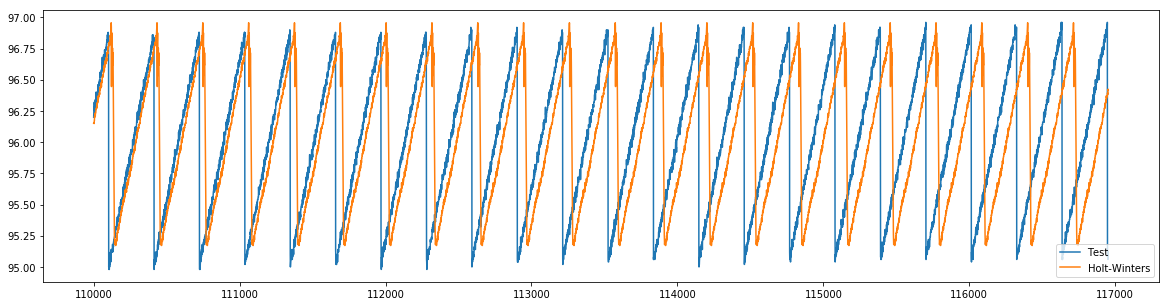

0.5230621469890807


In [29]:
### NGP prediction
performance(ngp_unit1,'ngp_unit1')

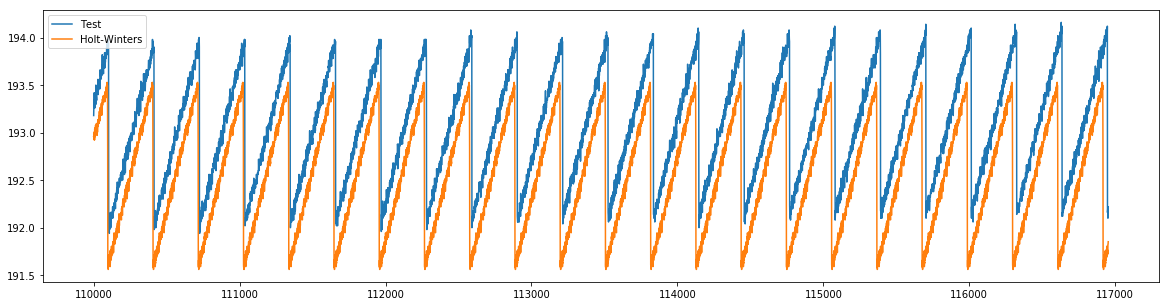

0.4629562045279687


In [24]:
performance(engine_pcd_unit1,'engine_pcd_unit1')

In [167]:
### npt_unit1 model training and pickling
serialize(npt_unit1 ,'npt_unit1',slice(89000,90000),test_idx,seasonal_periods=1000)

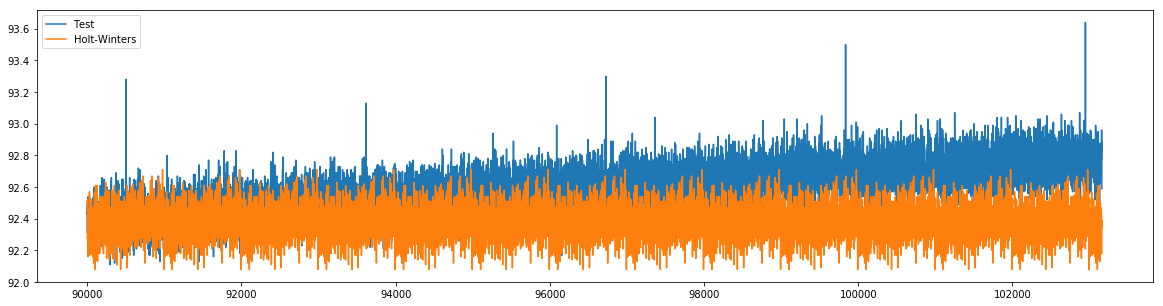

0.081556675024694


In [168]:
performance(npt_unit1 ,'npt_unit1')

In [151]:
### t1_temperature_unit1 model training and pickling
serialize(t1_temperature_unit1 ,'t1_temperature_unit1',train_idx,test_idx,seasonal_periods=310)

In [153]:
performance(t1_temperature_unit1 ,'t1_temperature_unit1')

In [148]:
### t5_average_temperature_unit1 model training and pickling
serialize(t5_average_temperature_unit1 ,'t5_average_temperature_unit1',train_idx,test_idx,seasonal_periods=313)

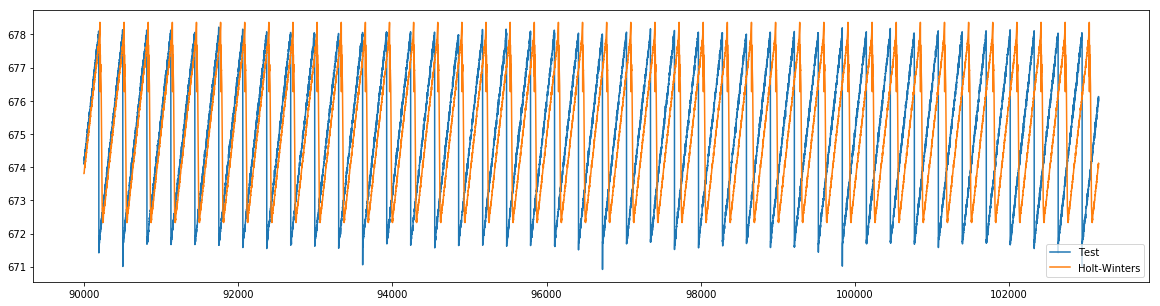

6.450498177643245


In [149]:
performance(t5_average_temperature_unit1 ,'t5_average_temperature_unit1')

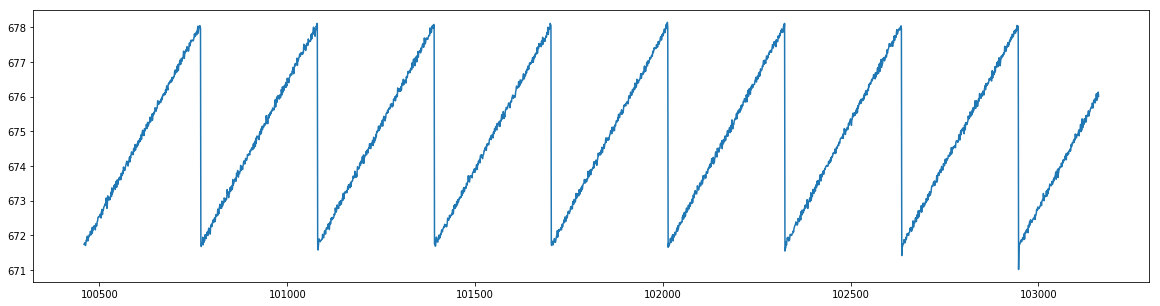

In [170]:
plt.plot(t5_average_temperature_unit1[100459:])

In [ ]:
with open('engine_pcd_unit1.pickle', 'rb') as handle:
    results_engine_pcd_unit1 = pickle.load(handle)
with open('npt_unit1.pickle', 'rb') as handle:
    results_npt_unit1 = pickle.load(handle)
with open('t1_temperature_unit1.pickle', 'rb') as handle:
    results_t1_temperature_unit1 = pickle.load(handle)
with open('t5_average_temperaure_unit1.pickle', 'rb') as handle:
    results_t5_average_temperature_unit1 = pickle.load(handle)
with open('ngp_unit1.pickle', 'rb') as handle:
    results_ngp_unit1 = pickle.load(handle)

In [64]:
df.shape

(116953, 8)

In [16]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(df['ngp'].copy()[80000:110000].values.reshape(-1,1))